In [12]:
using Pkg
Pkg.activate("../Project.toml")

include("../LogLoss/RealRealHighDimension.jl")
include("imputation.jl");
# include("../Interpolation/imputation.jl")
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


In [ ]:
# svpath_slb = "../Data/ecg200/mps_saves/sahand_legendre_ns_d20_chi100_range.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"
svpath_sl = "../Data/ecg200/mps_saves/sahand_legendre_ns_d20_chi100.jld2"
# svpath_leg = "../Data/ecg200/mps_saves/legendre_no_norm10_ns_d20_chi100.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"

dloc =  "../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



###################################3

f = jldopen(svpath_sl, "r")
    mps_sl = read(f, "mps")
    opts_sl = read(f, "opts")
close(f)

opts_sl, _... = safe_options(opts_sl, nothing, nothing)

fc_sl = init_imputation_problem(mps_sl, X_train, y_train, X_test, y_test, opts_sl);

# fc_sl = load_forecasting_info_variables(mps_sl, X_train, y_train, X_test, y_test, opts_sl);





++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
Slicing MPS into individual states...
 - 2 class(es) were detected.
 - Time independent encoding - Sahand-Legendre Time Independent - detected.
 - d = 20, chi_max = 100
Re-encoding the training data to get the encoding arguments...

 Created 2 ImputationProblem struct(s) containing class-wise mps and test samples.


ImputationProblem(MPS[MPS
[1] ((dim=20|id=690|"Site,n=1"), (dim=15|id=745|"Link,l=1"))
[2] ((dim=20|id=221|"Site,n=2"), (dim=15|id=745|"Link,l=1"), (dim=89|id=54|"Link,l=2"))
[3] ((dim=20|id=230|"Site,n=3"), (dim=89|id=54|"Link,l=2"), (dim=100|id=391|"Link,l=3"))
[4] ((dim=20|id=425|"Site,n=4"), (dim=100|id=391|"Link,l=3"), (dim=100|id=516|"Link,l=4"))
[5] ((dim=20|id=376|"Site,n=5"), (dim=100|id=516|"Link,l=4"), (dim=100|id=257|"Link,l=5"))
[6] ((dim=20|id=806|"Site,n=6"), (dim=100|id=257|"Link,l=5"), (dim=100|id=919|"Link,l=6"))
[7] ((dim=20|id=941|"Site,n=7"), (dim=100|id=919|"Link,l=6"), (dim=100|id=650|"Link,l=7"))
[8] ((dim=20|id=837|"Site,n=8"), (dim=100|id=650|"Link,l=7"), (dim=100|id=171|"Link,l=8"))
[9] ((dim=20|id=702|"Site,n=9"), (dim=100|id=171|"Link,l=8"), (dim=100|id=666|"Link,l=9"))
[10] ((dim=20|id=748|"Site,n=10"), (dim=100|id=666|"Link,l=9"), (dim=100|id=973|"Link,l=10"))
[11] ((dim=20|id=580|"Site,n=11"), (dim=100|id=973|"Link,l=10"), (dim=100|id=671|"Link,l=11"))
[

# Mean

In [4]:
class = 1
impute_sites = collect(6:21)
instance_idx = 59 # 4
invert_transform=true

true

  2.866234 seconds (16.36 M allocations: 1.414 GiB, 10.30% gc time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.616841 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


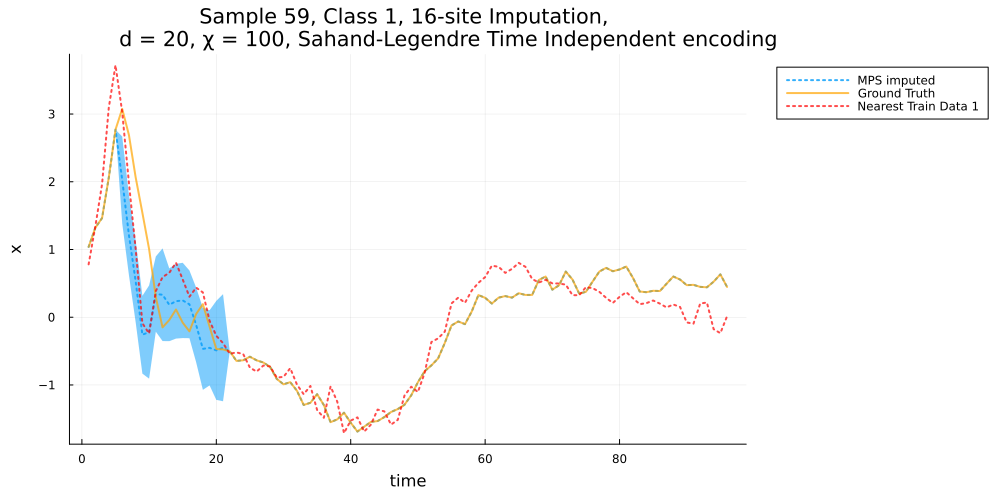

In [8]:

# run on rc2
@time begin 
    ts, pred_err, stats, p1_ns = MPS_impute(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMean; 
    invert_transform=invert_transform, 
    NN_baseline=true,
    n_baselines=1, 
    plot_fits=true
    );
end

pretty_table(stats[1]; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

In [16]:
mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index=Index(opts_sl.d)
xvals_enc= [get_state(x, opts_sl, fc_sl[1].enc_args) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

122.171156 seconds (52.93 M allocations: 133.498 GiB, 13.61% gc time, 2.70% compilation time: 26% of which was recompilation)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.616841 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


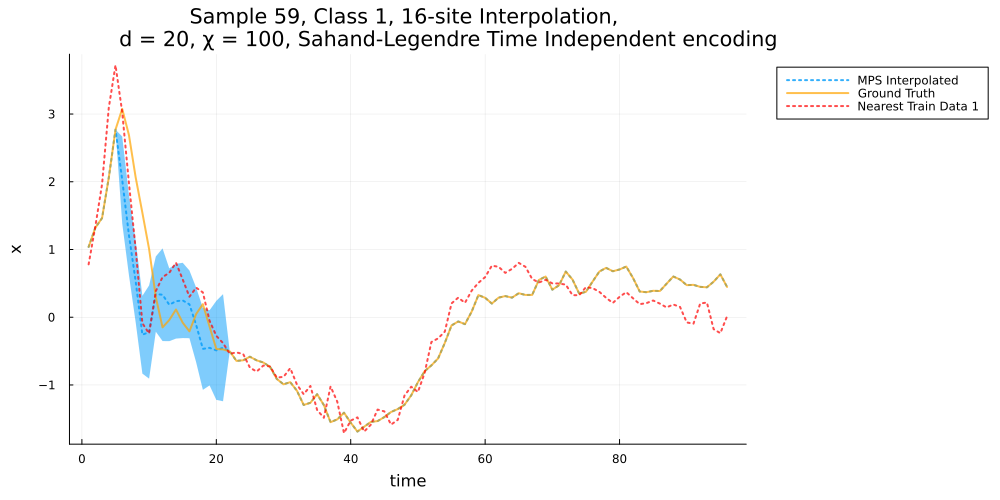

In [ ]:

# include("imputation.jl");
# run on josh3
@time begin 
    stats, p1_ns = any_impute_single_timeseries(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMean; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    X_train=X_train, 
    y_train=y_train, 
    n_baselines=1, 
    plot_fits=true,
    mode_range=mode_range, 
    xvals=xvals, 
    mode_index=mode_index, 
    xvals_enc=xvals_enc, 
    xvals_enc_it=xvals_enc_it
    );
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

# Mode

  2.936398 seconds (16.39 M allocations: 1.405 GiB, 10.83% gc time, 6.21% compilation time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.718846 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


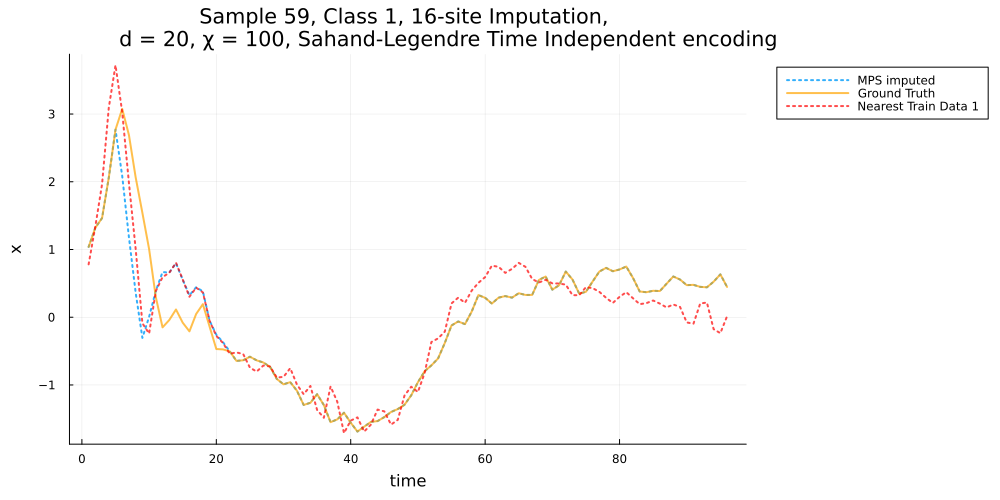

In [11]:

# run on rc2
@time begin 
    ts, pred_err, stats, p1_ns = MPS_impute(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMode; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    n_baselines=1, 
    plot_fits=true
    );
end

pretty_table(stats[1]; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

  5.809498 seconds (18.45 M allocations: 3.923 GiB, 16.86% gc time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.718846 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


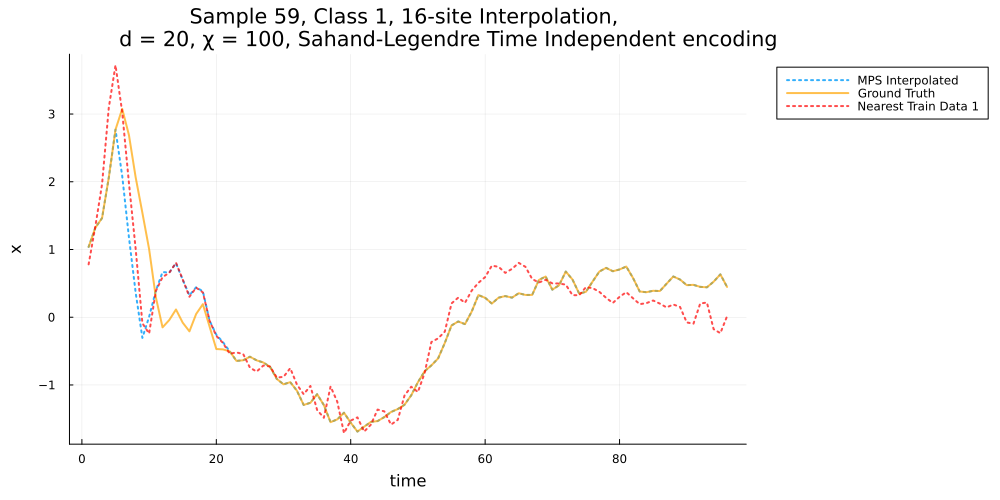

In [ ]:
# run on Josh3
@time begin 
    stats, p1_ns = any_impute_single_timeseries(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMode; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    X_train=X_train, 
    y_train=y_train, 
    n_baselines=1, 
    plot_fits=true,
    mode_range=mode_range, 
    xvals=xvals, 
    mode_index=mode_index, 
    xvals_enc=xvals_enc, 
    xvals_enc_it=xvals_enc_it
    );
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

# Median

  1.868672 seconds (16.51 M allocations: 1.448 GiB, 13.03% gc time, 9.28% compilation time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.637368 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


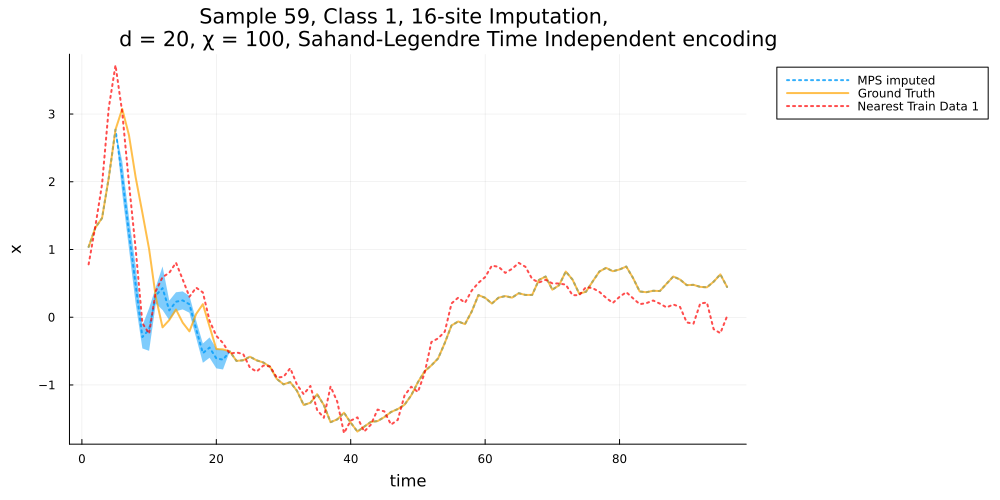

In [10]:
# run on rc2
@time begin 
    ts, pred_err, stats, p1_ns = MPS_impute(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMedian; 
    invert_transform=invert_transform, 
    NN_baseline=true,
    n_baselines=1, 
    plot_fits=true
    );
end

pretty_table(stats[1]; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

  6.920118 seconds (19.70 M allocations: 4.013 GiB, 15.18% gc time, 16.45% compilation time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.637368 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


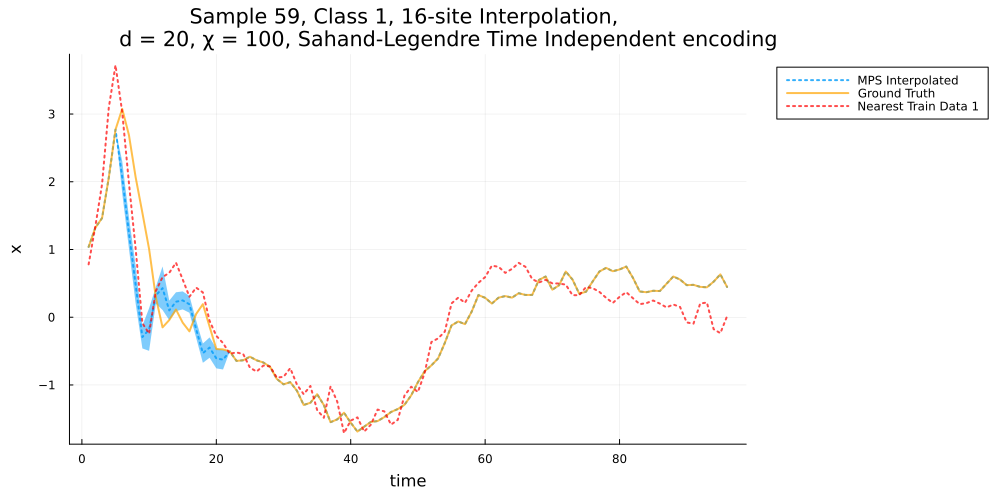

In [ ]:
# run on josh3
@time begin 
    stats, p1_ns = any_impute_single_timeseries(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :directMedian; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    X_train=X_train, 
    y_train=y_train, 
    n_baselines=1, 
    plot_fits=true,
    mode_range=mode_range, 
    xvals=xvals, 
    mode_index=mode_index, 
    xvals_enc=xvals_enc, 
    xvals_enc_it=xvals_enc_it
    );
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

# ITS

 14.204291 seconds (99.62 M allocations: 8.475 GiB, 13.56% gc time, 16.07% compilation time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.746301 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


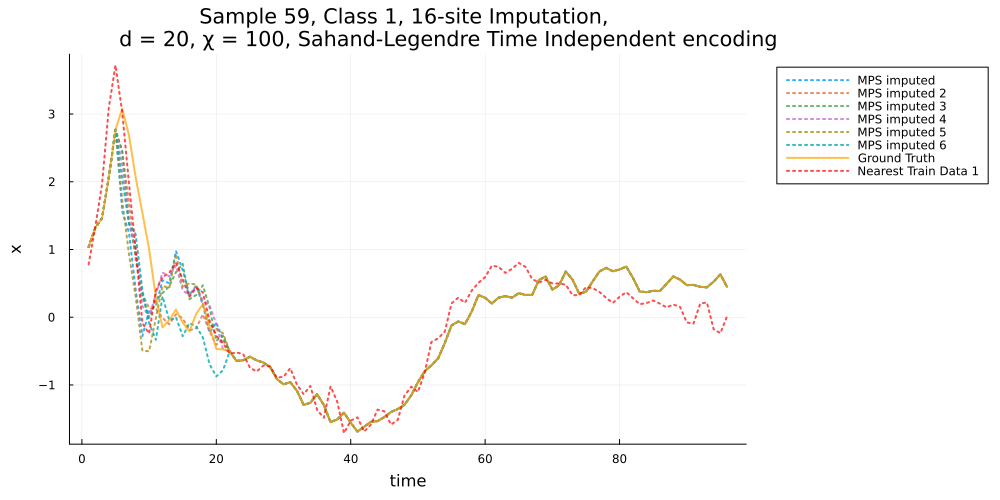

In [16]:
include("imputation.jl");
# run on rc2

@time begin 
    ts, pred_err, stats, p1_ns = MPS_impute(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :ITS; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    n_baselines=1, 
    plot_fits=true,
    rseed=1,
    rejection_threshold=2.5,
    num_trajectories=6
    );
    
end

pretty_table(stats[1]; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)

 48.131877 seconds (41.38 M allocations: 58.758 GiB, 10.87% gc time, 4.52% compilation time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.632475 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


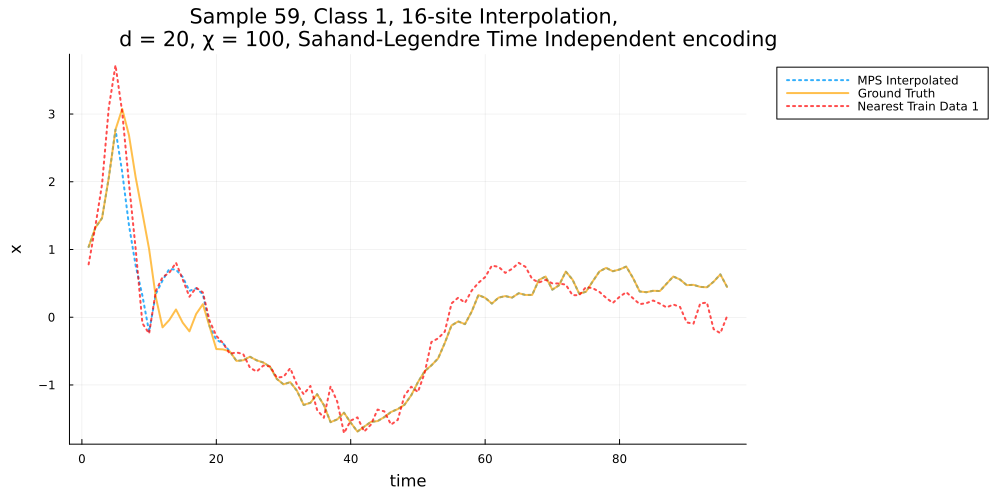

In [ ]:
# run on josh3
@time begin 
    stats, p1_ns = any_impute_single_timeseries(
    fc_sl, 
    class, 
    instance_idx, 
    impute_sites, 
    :ITS; 
    invert_transform=invert_transform, 
    NN_baseline=true, 
    X_train=X_train, 
    y_train=y_train, 
    n_baselines=1, 
    plot_fits=true,
    mode_range=mode_range, 
    xvals=xvals, 
    mode_index=mode_index, 
    xvals_enc=xvals_enc, 
    xvals_enc_it=xvals_enc_it
    );
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)